In [1]:
##Author Tushar Kant Roy
from os import listdir, makedirs
from os.path import isfile, join, basename, splitext, isfile, exists

import numpy as np
import pandas as pd

from tqdm import tqdm_notebook

import tensorflow as tf
import keras.backend as K

import keras
from keras.models import Sequential, Model
from keras.layers import Dropout, Dense, Flatten, BatchNormalization
from keras.layers import Convolution1D, ZeroPadding1D, MaxPooling1D, GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.layers import Concatenate, Average, Maximum, CuDNNLSTM, CuDNNGRU, Bidirectional, TimeDistributed
from keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from keras.engine.input_layer import Input
from keras.models import load_model

import matplotlib.pyplot as plt

Using TensorFlow backend.


In [2]:
pd.set_option('precision', 30)
np.set_printoptions(precision = 30)

np.random.seed(7723)
tf.set_random_seed(1090)

In [3]:
###Read the data
train_df = pd.read_csv('../data/train.csv', dtype={'acoustic_data': np.int8, 'time_to_failure': np.float32})

In [9]:

#####Length of training sample
print(train_df.acoustic_data.values.shape)

###Assign train smaples and label
X_train = train_df.acoustic_data.values
y_train = train_df.time_to_failure.values

### Find different segments in the training data 
ends_mask = np.less(y_train[:-1], y_train[1:])
segment_ends = np.nonzero(ends_mask)
train_segments = []
start = 0
for end in segment_ends[0]:
    train_segments.append((start, end))
    start = end
    
print(train_segments)
print(len(train_segments))

(629145480,)
[(0, 5656573), (5656573, 50085877), (50085877, 104677355), (104677355, 138772452), (138772452, 187641819), (187641819, 218652629), (218652629, 245829584), (245829584, 307838916), (307838916, 338276286), (338276286, 375377847), (375377847, 419368879), (419368879, 461811622), (461811622, 495800224), (495800224, 528777114), (528777114, 585568143), (585568143, 621985672)]
16


In [43]:
print(y_train[5656573])

0.0007954798


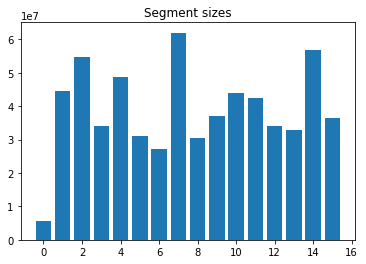

In [44]:
plt.title('Segment sizes')
_ = plt.bar(np.arange(len(train_segments)), [ s[1] - s[0] for s in train_segments])

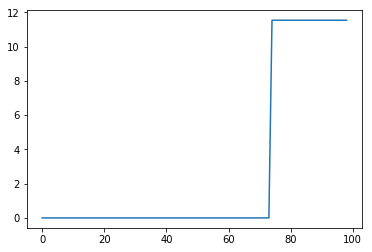

In [45]:
plt.plot([i for i in range(len(y_train[5656500:5656599]))], y_train[5656500:5656599])

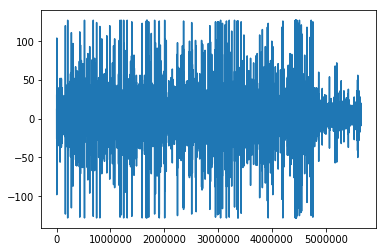

In [46]:
plt.plot([i for i in range(len(X_train[0:5656573]))],X_train[0:5656573])

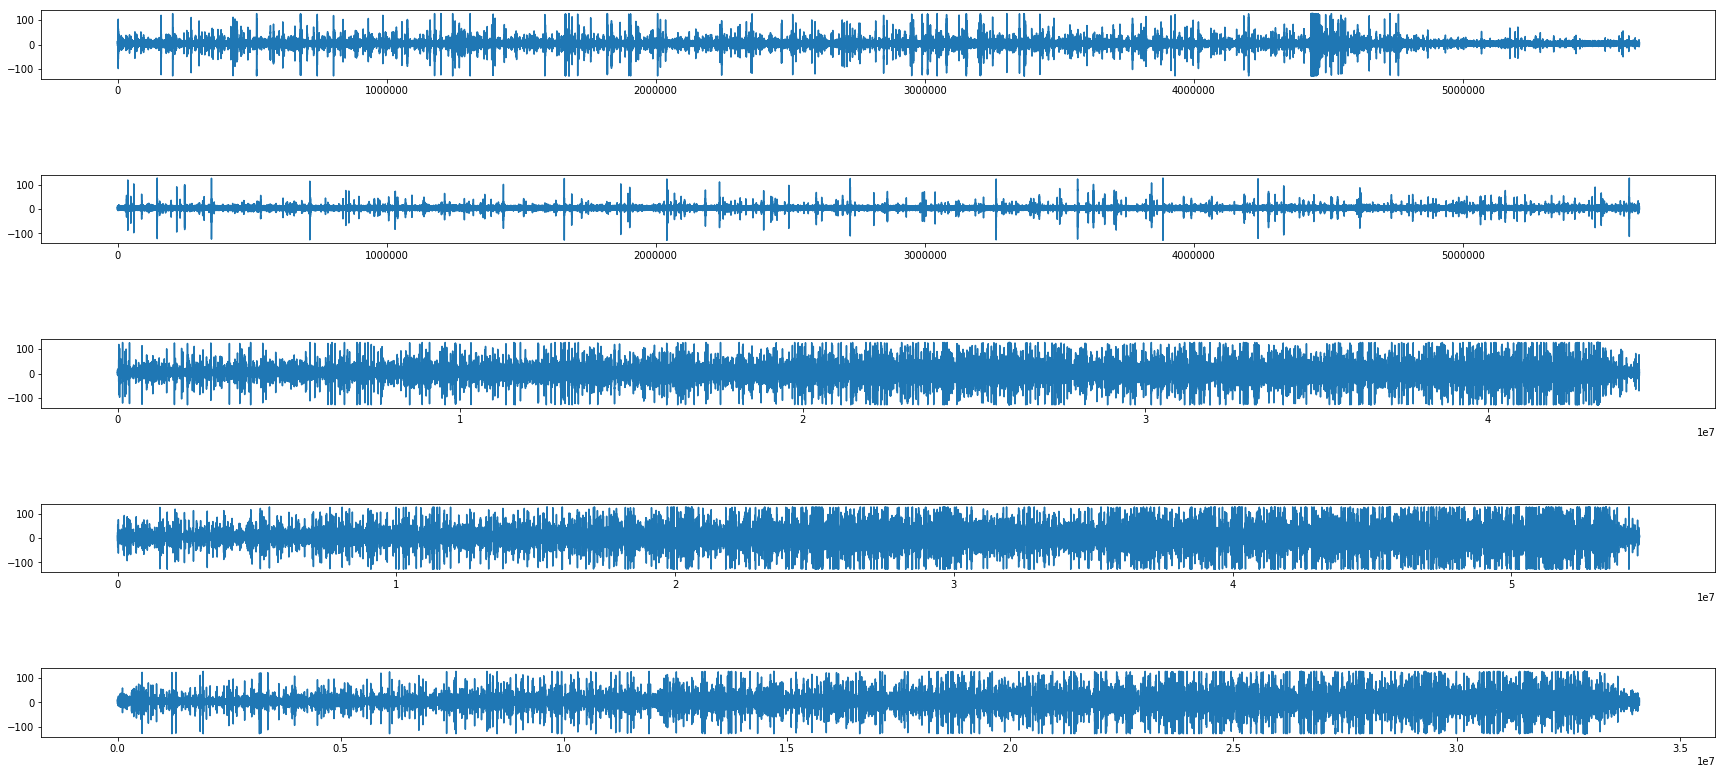

In [47]:
from matplotlib import gridspec
plt.figure(figsize=(30,30))
plt.subplot2grid((20,1),(0,0),colspan=2)
plt.plot([i for i in range(len(X_train[0:5656573]))],X_train[0:5656573])
plt.subplot2grid((20,1),(2,0),colspan=2)
plt.plot([i for i in range(len(X_train[5656573:11313146]))],X_train[5656573:11313146])
plt.subplot2grid((20,1),(4,0),colspan=2)
plt.plot([i for i in range(len(X_train[5656573:50085877]))],X_train[5656573:50085877])
plt.subplot2grid((20,1),(6,0),colspan=2)
plt.plot([i for i in range(len(X_train[50085877:104677355]))],X_train[50085877:104677355])
plt.subplot2grid((20,1),(8,0),colspan=2)
plt.plot([i for i in range(len(X_train[104677355:138772452]))],X_train[104677355: 138772452])
plt.show()

/Users/tushar/Library/Python/3.7/lib/python/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


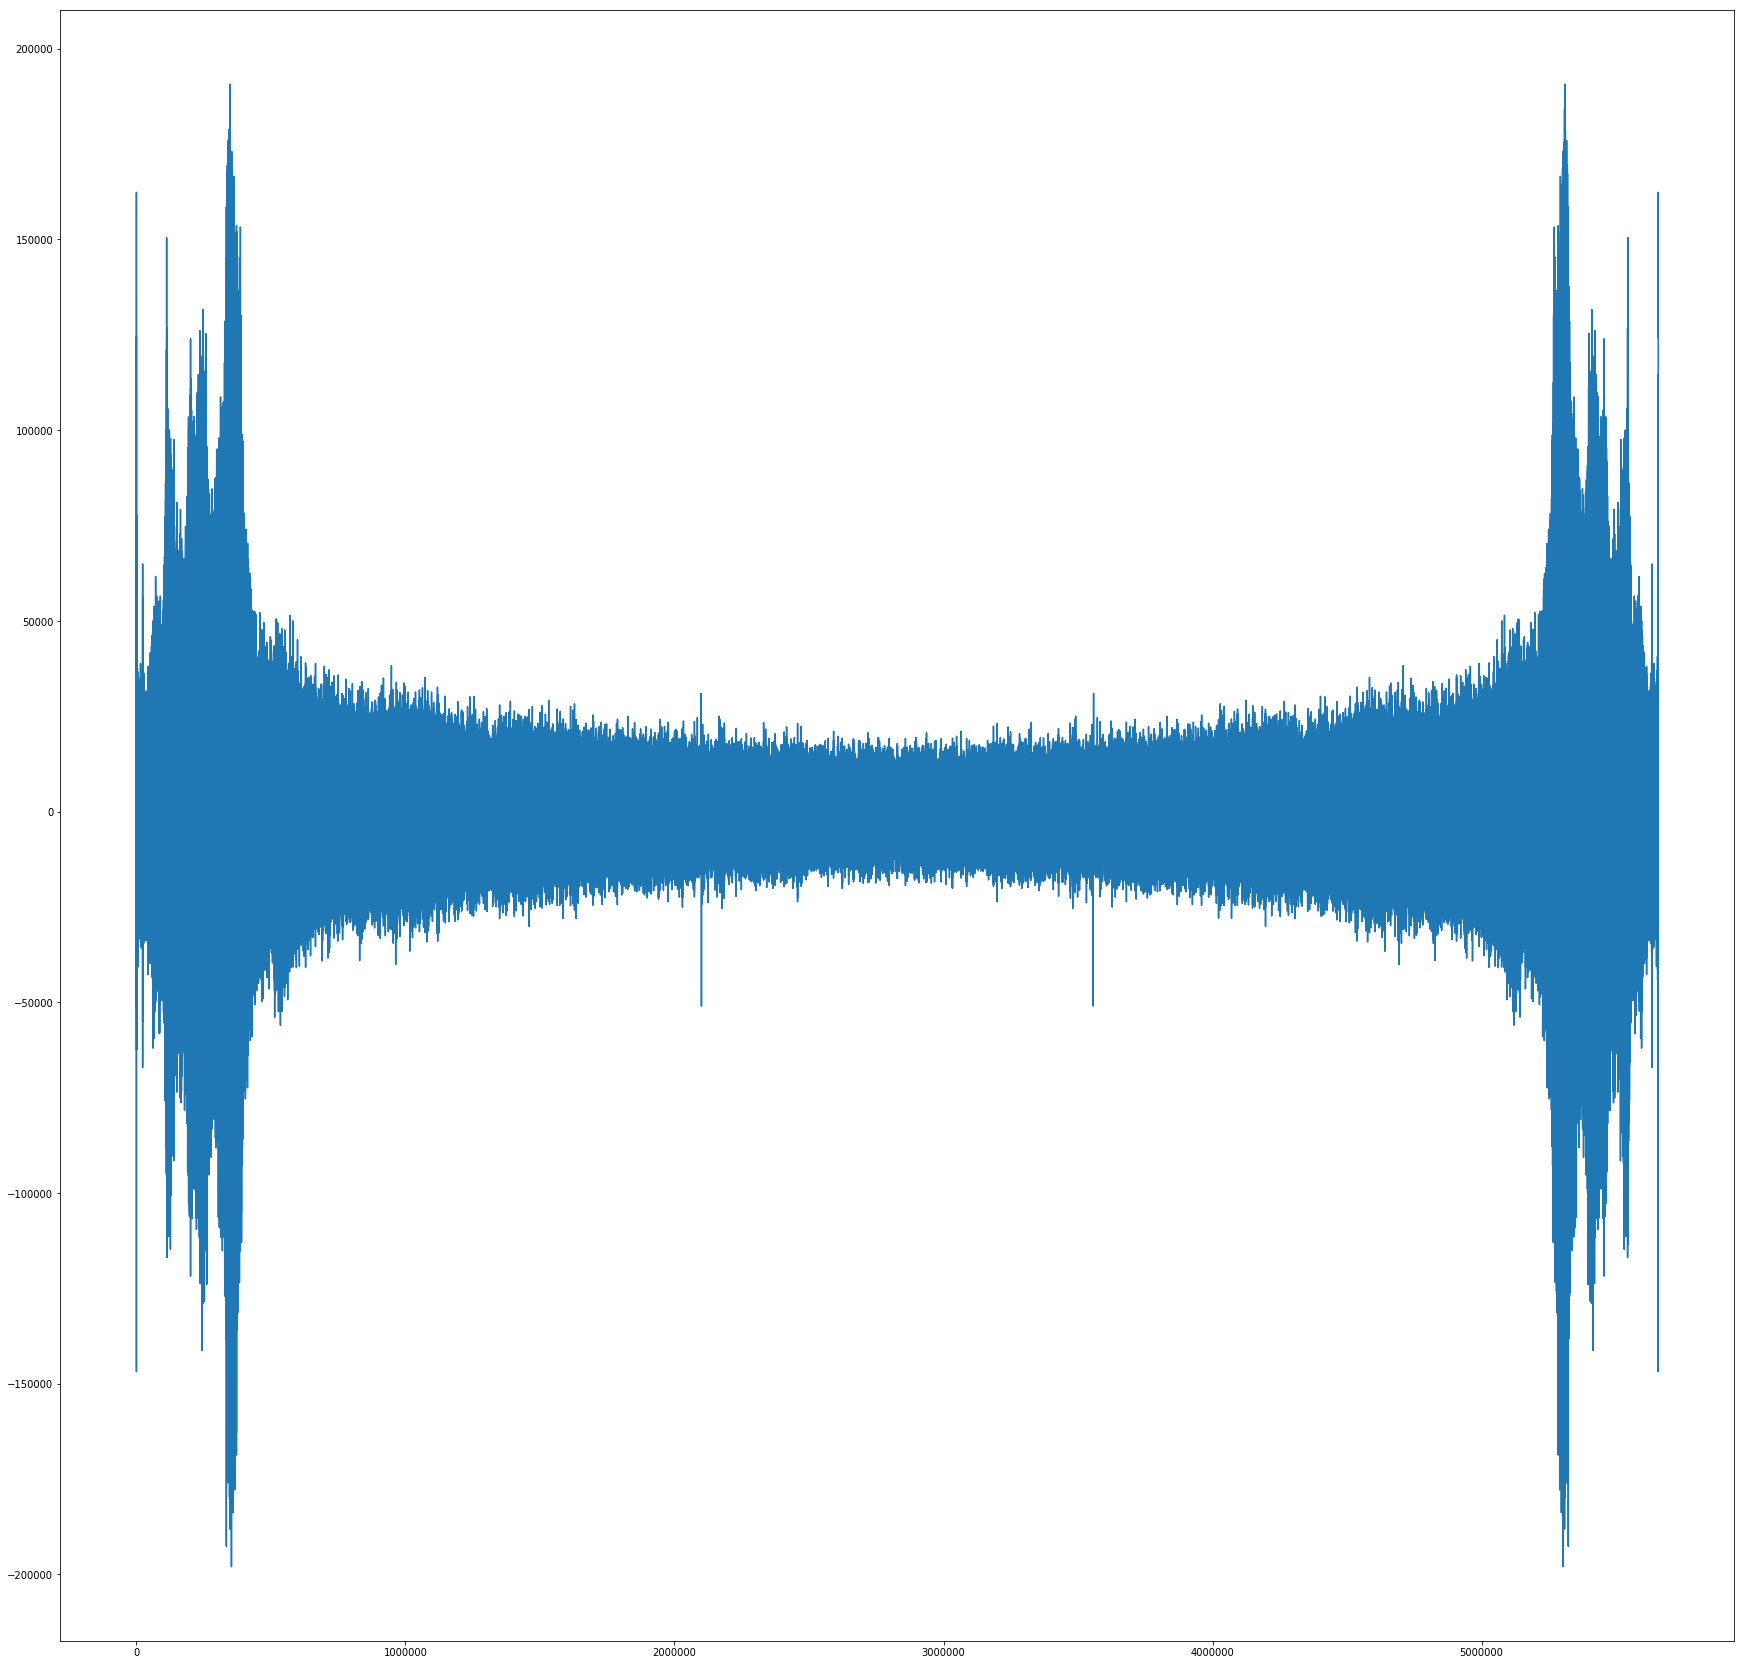

In [50]:
from scipy.fftpack import fft, ifft
S1_fft = fft(X_train[0:5656573])
S1_fft = S1_fft[1:]
plt.figure(figsize=(30,30))
plt.plot([i for i in range(len(S1_fft))],S1_fft)
plt.show()

/Users/tushar/Library/Python/3.7/lib/python/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


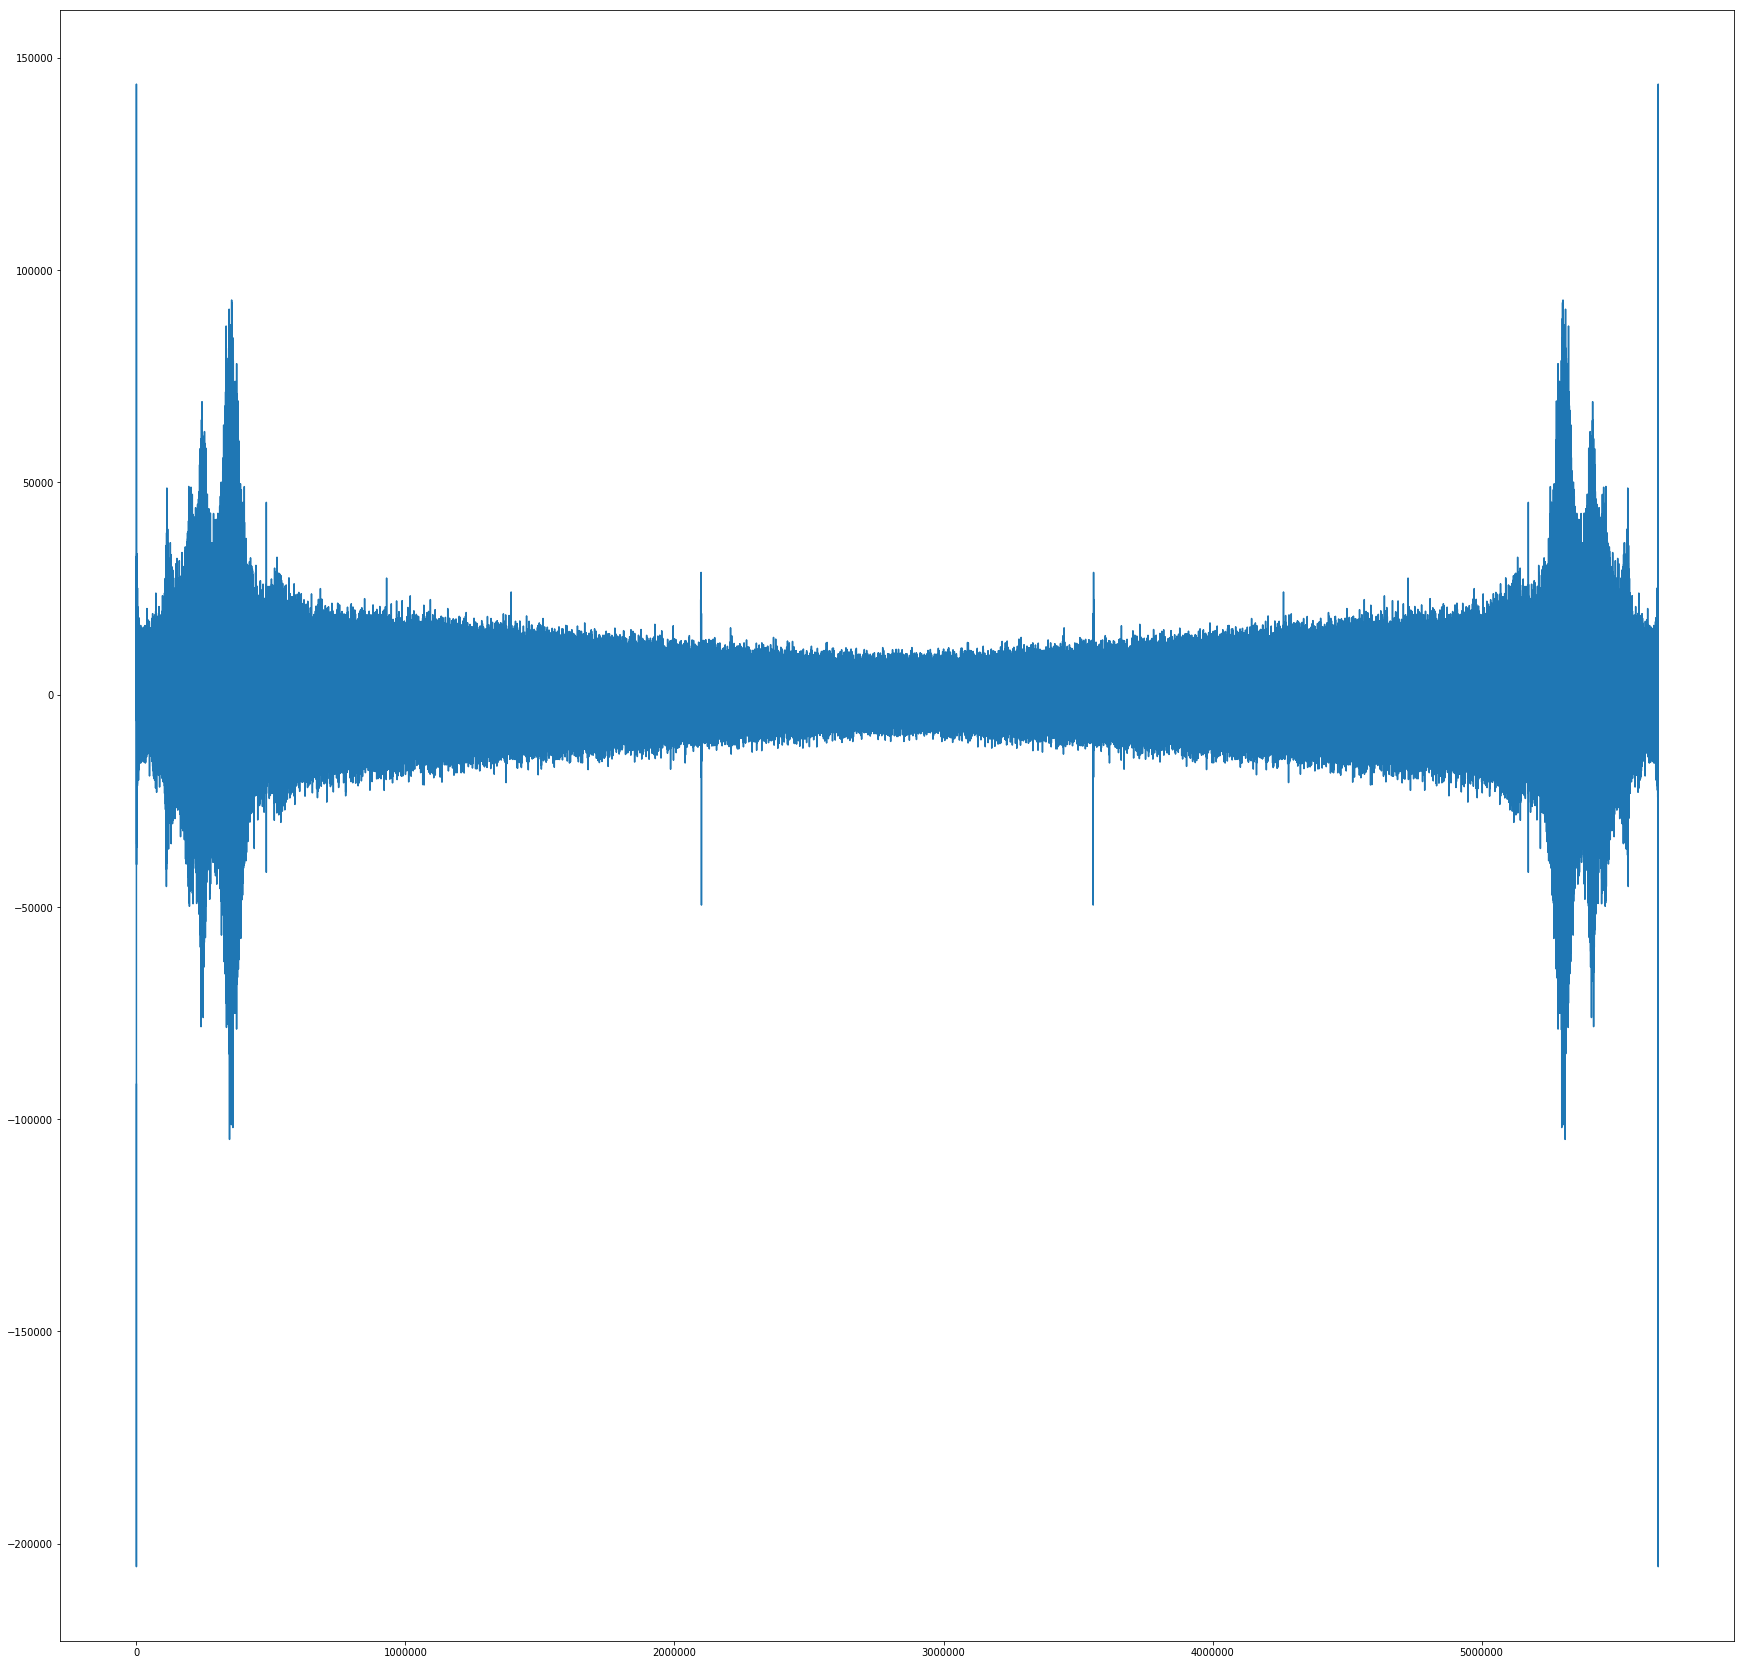

In [51]:
S2_fft = fft(X_train[5656573:11313146])
S2_fft = S2_fft[1:]
plt.figure(figsize=(30,30))
plt.plot([i for i in range(len(S2_fft))],S2_fft)
plt.show()

In [ ]:
S3_fft = fft(X_train[5656573:50085877])
S3_fft = np.where(S3_fft < 600000)
plt.figure(figsize=(30,30))
plt.plot([i for i in range(len(S3_fft))],S3_fft)
plt.show()